<a href="https://colab.research.google.com/github/Divyesh-Kanagavel/deep_learning--keras/blob/master/multicat_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook 

     |████████████████████████████████| 719 kB 7.8 MB/s 
     |████████████████████████████████| 451 kB 35.2 MB/s 
     |████████████████████████████████| 5.8 MB 53.0 MB/s 
     |████████████████████████████████| 1.3 MB 47.5 MB/s 
     |████████████████████████████████| 1.6 MB 27.5 MB/s 
     |████████████████████████████████| 182 kB 32.9 MB/s 
     |████████████████████████████████| 132 kB 34.6 MB/s 
     |████████████████████████████████| 212 kB 44.6 MB/s 
     |████████████████████████████████| 127 kB 15.0 MB/s 
     |████████████████████████████████| 7.6 MB 18.6 MB/s 


In [2]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
from fastbook import *

Other CV problems : Multi-label classification , regression
Multi-label classification is not widely used, but practically very useful.
A single image could be trained to learn multiple classes or no object of any class etc.

This could be achieved with the same model with some modifications - example, we would change the loss function from categorical cross entropy etc.

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [5]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/test.json')]

In [6]:
import pandas as pd
df = pd.read_csv(path/'train.csv')

In [7]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [8]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [9]:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

Dataset : A combination of independent and dependent variable(x,y) in tuple. DataLoader : Sets of data in mini-batches with an iterator, which iterates across the datasets.
Datasets  : the training and validation datasets together
DataLoaders : Class that operates on training and validation dataloaders.

Step-by-step building of dataset and dataloader using DataBlock API

In [10]:
dblock = DataBlock()

In [11]:
dsets = dblock.datasets(df)

In [12]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [13]:
x,y = dsets.train[0]

In [14]:
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [15]:
dsets.train[0]

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

Since we created dblock with the default constructor and not passing right input,it takes dataframe twice and assigns it to x and y

In [16]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

The input is the image,so we need to pass the complete path to the image.
Also,the label could have two words together, so we could use split

In [17]:
def get_x(r) : return path/'train'/r['fname']
def get_y(r) : return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/002549.jpg'), ['tvmonitor'])

We would like to convert the images to tensors for operating on them. the DataBlock API is capable of transforming the images to tensors and the labels to appropriate data structure

In [18]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),get_x = get_x, get_y = get_y)

In [19]:
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x325,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

for multicategory problem, the multicategoryblock uses one-hot encoding, because in each image, the list of labels would be of different length, but tensors require constant length.hence One-hot encoding is used.

In [20]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
print(type(idxs))
dsets.train.vocab[idxs]

<class 'fastai.torch_core.TensorMultiCategory'>


(#1) ['train']

In [21]:
#explicitly ask the datablock to split train and validation set based on input df data

def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train,valid

In [22]:
dblock = DataBlock(blocks=(ImageBlock,MultiCategoryBlock), get_x = get_x, get_y = get_y, splitter = splitter)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Before passing the dataset as Dataloader to be fed as batches to GPU, we need to make sure each element in dataset is of the samesize.

In [23]:
dblock = DataBlock(blocks=(ImageBlock,MultiCategoryBlock), get_x = get_x, get_y = get_y, splitter=splitter, item_tfms=RandomResizedCrop(128,min_scale=0.35))
dls=dblock.dataloaders(df)

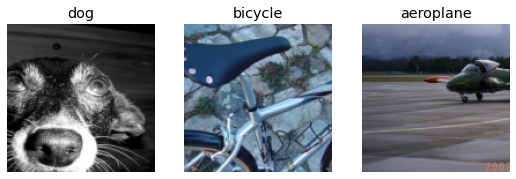

In [24]:
dls.show_batch(nrows=1,ncols=3)

In [25]:
learn = vision_learner(dls,resnet18)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [26]:
(x,y) = to_cpu(dls.train.one_batch()) # if to_cpu is not called, the type of dls.train.one_batch() will be torch.cuda.FloatTensor, but the models are of type torch.FloatTensor

In [27]:
activs = learn.model(x)

In [28]:
activs.shape   # 64 samples in a single batch and also, there are 20 categories for which labelling could be done.

torch.Size([64, 20])

In [29]:
activs[0] 

TensorBase([ 0.4153,  1.2974, -2.9310,  1.3063, -0.6814, -1.7772,  0.8123, -0.4988, -1.6027,  1.3562,  1.2609,  0.0103,  2.3019, -0.4606, -0.4662,  0.6359, -3.2023, -0.8144, -3.8843, -0.8441],
           grad_fn=<AliasBackward0>)

The output from the network are not in the range [0,1], sigmoid could be used just like in binary_cross_entropy. Then, log likelihood loss could be used.

In [30]:
def binary_cross_entropy(inputs,targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets == 1, inputs, 1-inputs).log().mean()

Pytorch provides these functions either with or without sigmoid applied. We could use the one which does both sigmoid and Binary Cros Entropy Loss

when we have multiple labels as desired outputs, softmax+nll loss is a bad idea, softmax makes the sum of all activations to 1, highlighting just one probable value. also, nll loss is designed for single label and doesnt make sense for multilabel classification.

In [31]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs,y)
loss

TensorMultiCategory(1.0954, grad_fn=<AliasBackward0>)

Accuracy cannot be used as a metric for multi-label classification.it could be used for checking if one label is correct for not. for multi-label classification, a slight modification is needed.

In [32]:
def accuracy_multi(inp,targ,thresh=0.5, sigmoid=True):
  if sigmoid:
    inp = inp.sigmoid()

  return ((inp > thresh) == targ.bool()).float().mean()



Partial in python could be used to pass a function as an argument along with its modifiable arguments .

In [33]:
def say_hello(name,say_what="Hello") : return f"{say_what} {name}.";
say_hello("Divyesh"), say_hello("Divyesh", "Hi")


('Hello Divyesh.', 'Hi Divyesh.')

In [34]:
f = partial(say_hello,say_what="Vanakkam")
f("Divyesh"), f("Kanagavel")

('Vanakkam Divyesh.', 'Vanakkam Kanagavel.')

In [35]:
learn = vision_learner(dls, resnet50,metrics=partial(accuracy_multi,thresh=0.2))  

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [37]:
learn.fine_tune(3,base_lr=3e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy_multi,time


KeyboardInterrupt: ignored

In [ ]:
learn.metrics = partial(accuracy_multi,thresh=0.1)
learn.validate()

In [ ]:
learn.metrics = partial(accuracy_multi,thresh=0.99)

In [ ]:
learn.validate()

In [ ]:
preds,targs = learn.get_preds()

In [ ]:
accuracy_multi(preds,targs,thresh=0.9, sigmoid=False)

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds,targs,thresh=i,sigmoid=False) for i in xs]
plt.plot(xs,accs);

Regression problem in computer vision:

Possibilities of using deep learning models are endless! As long as we have a dataset containing a independent variable(could be images, text etc) and a dependent variable (could be image, text, values etc). 

A tricky problem : Given an image, a keypoint is to be deduced. (x,y) of a person's face in an image.

In [38]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [39]:
Path.BASE_PATH = path

In [40]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [41]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [42]:
img_files = get_image_files(path)
def img2pose(x) : return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('01/frame_00211_pose.txt')

In [43]:
im = PILImage.create(img_files[0])

In [44]:
im.shape

(480, 640)

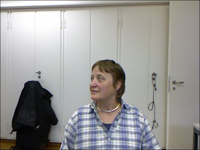

In [45]:
im.to_thumb(200)

In [46]:
cal = np.genfromtxt(path/'01'/'rgb.cal',skip_footer=6)

In [47]:
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f),skip_header=3)
  c1 = ctr[0]*cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1]*cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1,c2])

  

In [48]:
get_ctr(img_files[0])

tensor([324.3246, 262.9280])

In [49]:
biwi = DataBlock(blocks = (ImageBlock,PointBlock),get_items=get_image_files, get_y = get_ctr,
                 splitter=FuncSplitter(lambda o : o.parent.name == '13'), batch_tfms=aug_transforms(size=(240,320)),)

In [50]:
dls = biwi.dataloaders(path)

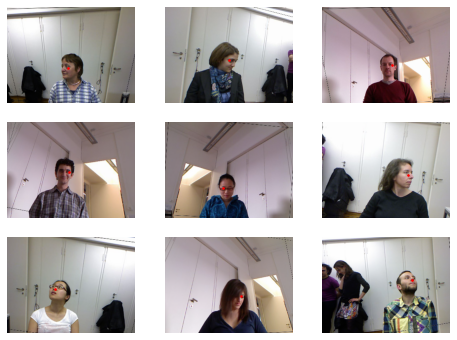

In [51]:
dls.show_batch(max_n=9, figsize=(8,6) )

In [52]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [53]:
yb[0]

TensorPoint([[-0.2476,  0.1552]])

In [54]:
yb[5]

TensorPoint([[0.0706, 0.0884]])

In [55]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


y_range , tells the vision_learner class that the dependent variable is in the range (-1,1) : the coordinates of the face are normalized

In [57]:
#implentation of y_range
def sigmoid_range(x,lo,hi) : return torch.sigmoid(x)*(hi-lo) + lo

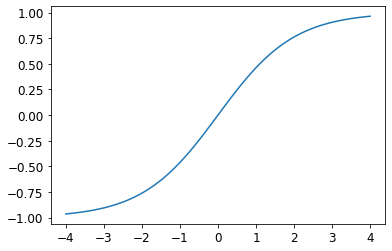

In [58]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4,max=4)

In [59]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.00363078061491251)

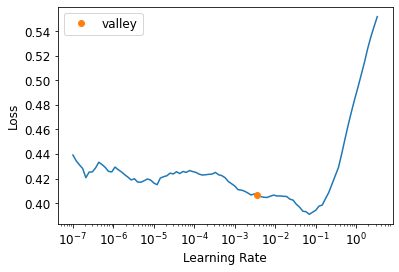

In [60]:
learn.lr_find()

In [61]:
lr = 1e-2
learn.fine_tune(1,lr)

epoch,train_loss,valid_loss,time


KeyboardInterrupt: ignored

Ran out of GPU on colab.So, the regression problem is solved in another platform like Kaggle or Paperspace gradient